# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_0 = decontracted(sent_0)
print(sent_0)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_0 = re.sub('[^A-Za-z0-9]+', ' ', sent_0)
print(sent_0)

My dogs loves this chicken but its a product from China so we wont be buying it anymore Its very hard to find any chicken products made in the USA but they are out there but this one isnt Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:48<00:00, 1827.28it/s]


In [23]:
preprocessed_reviews[150]

'dog toy huge hit house added bulldog puppy family awake teeth constantly seeking something sink toy hard enough hold not hard loses interest irregular shapes great giving multiple chew spots toy dinosaur even brought puppy old mix never big chew toys ca not go wrong one'

# [4] Featurization

## [4.1] TF-IDF

In [24]:
tf_idf_vect = TfidfVectorizer(min_df=10, max_features=3000)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'absolute', 'absolutely', 'acai', 'acceptable', 'according', 'acid', 'acidic', 'acidity']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (87773, 3000)
the number of unique words including both unigrams and bigrams  3000


## Truncated-SVD

### [5.1] Taking top features from TFIDF,<font color='red'> SET 2</font>

In [25]:
#Selecting top 3000 features
top_3000 = tf_idf_vect.get_feature_names()

### [5.2] Calulation of Co-occurrence matrix

In [26]:
from tqdm import tqdm

co_occ_matrix = np.zeros([3000,3000]) # Co-occurence matrix of size 3000*3000
window = 5   # n_neighbors
for sentence in tqdm(preprocessed_reviews):
    words_in_sentence = sentence.split()
    for index, word in enumerate(words_in_sentence):
        if word in top_3000:
            for i in range(max(index - window,0),min(index + window,len(words_in_sentence)-1)+1):
                if words_in_sentence[i] in top_3000:
                    co_occ_matrix[top_3000.index(word),top_3000.index(words_in_sentence[i])]+=1
                else:
                    pass
        else:
            pass

100%|████████████████████████████████████████████████████████████████████████████| 87773/87773 [59:21<00:00, 24.65it/s]


### [5.3] Finding optimal value for number of components (n) to be retained.

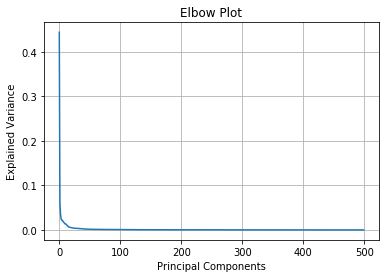

In [27]:
from sklearn.decomposition import TruncatedSVD
model = TruncatedSVD(n_components=500, algorithm='randomized', random_state=1)
model.fit_transform(co_occ_matrix)

plt.plot(model.explained_variance_ratio_)
plt.grid()
plt.title("Elbow Plot")
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance")
plt.show()

In [28]:
# Applying TruncatedSVD on prinipal components that show maximum variance
svd = TruncatedSVD(n_components=5, algorithm='randomized', random_state=1)
svd_result = svd.fit_transform(co_occ_matrix)

### [5.4] Applying k-means clustering

In [29]:
from sklearn.cluster import KMeans

# Applyying KMeans on 5 Clusters
cluster =KMeans(n_clusters=5, init='k-means++', random_state=1, n_jobs=-1)
pred_cluster = cluster.fit_predict(svd_result)   # Compute cluster centers and predict cluster index for each sample

print(pred_cluster.shape)
print(type(pred_cluster))

(3000,)
<class 'numpy.ndarray'>


### [5.5] Wordclouds of clusters obtained in the above section

In [30]:
from wordcloud import WordCloud

list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

No. of reviews in cluster-0:  2960


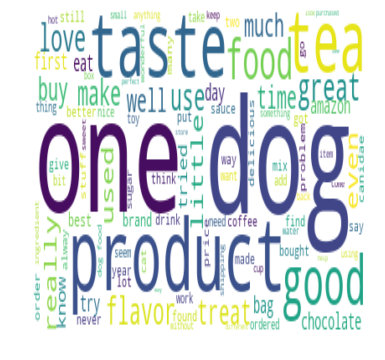

In [31]:
# Word Cloud for 0th Cluster

#Fetching reviews for cluster 0
reviews = []
for i in range(len(pred_cluster)):
    if pred_cluster[i] == 0:
        reviews.append(list_of_sentance[i])
        
print("No. of reviews in cluster-0: ", len(reviews))
        
words_in_reviews = ' '.join([str(word) for sublist in reviews for word in sublist])
    
plt.figure(figsize=(6,6))
word_cloud = WordCloud(max_words=100, background_color="white").generate(words_in_reviews)
plt.imshow(word_cloud,aspect='auto', interpolation='bilinear')
plt.axis('off')
plt.show()

No. of reviews in cluster-1:  1


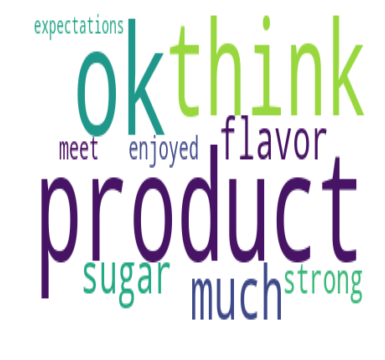

In [32]:
# Word Cloud for 1st Cluster

#Fetching reviews for cluster 1
reviews = []
for i in range(len(pred_cluster)):
    if pred_cluster[i] == 1:
        reviews.append(list_of_sentance[i])
        
print("No. of reviews in cluster-1: ", len(reviews))
        
words_in_reviews = ' '.join([str(word) for sublist in reviews for word in sublist])
    
plt.figure(figsize=(6,6))
word_cloud = WordCloud(max_words=100, background_color="white").generate(words_in_reviews)
plt.imshow(word_cloud,aspect='auto', interpolation='bilinear')
plt.axis('off')
plt.show()

No. of reviews in cluster-2:  1


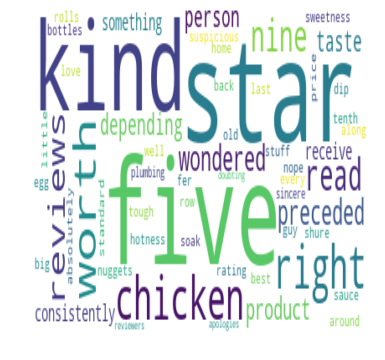

In [33]:
# Word Cloud for 2nd Cluster

#Fetching reviews for cluster 2
reviews = []
for i in range(len(pred_cluster)):
    if pred_cluster[i] == 2:
        reviews.append(list_of_sentance[i])
        
print("No. of reviews in cluster-2: ", len(reviews))
        
words_in_reviews = ' '.join([str(word) for sublist in reviews for word in sublist])
    
plt.figure(figsize=(6,6))
word_cloud = WordCloud(max_words=100, background_color="white").generate(words_in_reviews)
plt.imshow(word_cloud,aspect='auto', interpolation='bilinear')
plt.axis('off')
plt.show()

No. of reviews in cluster-3:  1


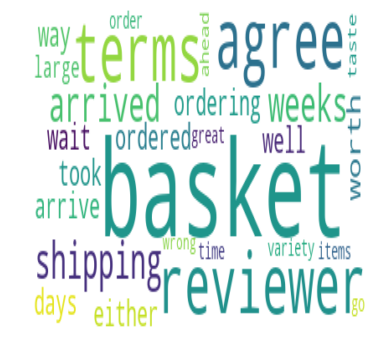

In [34]:
# Word Cloud for 3rd Cluster

#Fetching reviews for cluster
reviews2 = []
for i in range(len(pred_cluster)):
    if pred_cluster[i] == 3:
        reviews2.append(list_of_sentance[i])
        
print("No. of reviews in cluster-3: ", len(reviews2))
            
words_in_reviews2 = ' '.join([str(word) for sublist in reviews2 for word in sublist])
    
plt.figure(figsize=(6,6))
word_cloud = WordCloud(max_words=100, background_color="white").generate(words_in_reviews2)
plt.imshow(word_cloud,aspect='auto', interpolation='bilinear')
plt.axis('off')
plt.show()

No. of reviews in cluster-4:  37


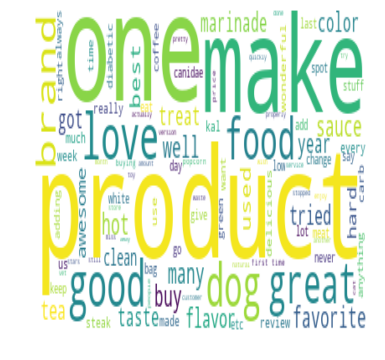

In [35]:
# Word Cloud for 4th Cluster

#Fetching reviews for cluster 4
reviews = []
for i in range(len(pred_cluster)):
    if pred_cluster[i] == 4:
        reviews.append(list_of_sentance[i])
        
print("No. of reviews in cluster-4: ", len(reviews))
        
words_in_reviews = ' '.join([str(word) for sublist in reviews for word in sublist])
    
plt.figure(figsize=(6,6))
word_cloud = WordCloud(max_words=100, background_color="white").generate(words_in_reviews)
plt.imshow(word_cloud,aspect='auto', interpolation='bilinear')
plt.axis('off')
plt.show()

### [5.6] Function that returns most similar words for a given word.

In [36]:
from sklearn.metrics.pairwise import cosine_similarity

def Get_SimilarWords(word):
    similarity = cosine_similarity(co_occ_matrix)
    print("Shape of cosine similarity result", similarity.shape)
    print("Type of cosine similarity result", type(similarity.shape))
    
    word_vect = similarity[top_3000.index(word)]
    print("Word Vector: ", word_vect,"\n")
    
    print("Selecting top 10 similar words to",word,"\n")
    
    # Sorted in reverse order and then selected top 10
    index = word_vect.argsort()[::-1][1:11]
    for i in range(len(index)):
        print((i+1),"Word",top_3000[index[i]] ,"is similar to",word,"\n")

In [37]:
Get_SimilarWords(top_3000[1])

Shape of cosine similarity result (3000, 3000)
Type of cosine similarity result <class 'tuple'>
Word Vector:  [0.17068848 1.         0.13970334 ... 0.15115048 0.12824502 0.1246969 ] 

Selecting top 10 similar words to able 

1 Word not is similar to able 

2 Word find is similar to able 

3 Word anymore is similar to able 

4 Word anywhere is similar to able 

5 Word locally is similar to able 

6 Word stores is similar to able 

7 Word hesitate is similar to able 

8 Word get is similar to able 

9 Word ca is similar to able 

10 Word thrilled is similar to able 



# [6] Conclusions

* Taken top 3000 features based on TFIDF values.
* Created Co-occurance Matrix with these 3000 features
* Applied Truncated SVD on co-occurance matrix with optimal no. of components.
* Applied Kmeans on truncated SVD to analyse the clusters.
* Plotted the Word Cloud of all 5 clusters to analyse what type of words it contain.